In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import lightgbm as lgb
from sklearn import preprocessing

pd.set_option('display.max_columns', None)

***
## loading data

In [2]:
train = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
test  = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return 'balanced_logloss', (log_loss0 + log_loss1)/2, False 

In [5]:
pct = train.Class.value_counts(normalize=True)
pos_weight = pct[0]/pct[1]
print("pos_weight:", pos_weight)

model_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.005,
    'num_leaves': 8,
    'bagging_freq': 1,
    'seed': 2112,
    'verbosity': 0,
    'first_metric_only': False,
    'bin_construct_sample_cnt': int(1e6),
    'feature_pre_filter': False,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_data_in_leaf': 10,
    'path_smooth': 1,
    'max_bin': 127,
    # for dealing with unbalance
    'scale_pos_weight':pos_weight,
}

pos_weight: 4.712962962962963


In [6]:
VERBOSE = False

models = list()
metrics = list()


for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
    
        train_df = train.loc[train_idx,:].reset_index(drop=True)
        valid_df = train.loc[valid_idx,:].reset_index(drop=True)

        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_cols],
            label=train_df.loc[:,"Class"].values,
            free_raw_data=False
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_cols],
            label=valid_df.loc[:,"Class"].values,
            free_raw_data=False
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            num_boost_round=2000,
            feval=[balanced_logloss],
            callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(100)],
        )
        
        if VERBOSE:
            lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
            plt.show()
            lgb.plot_importance(model, importance_type="split", figsize=(8,15))
            plt.show()

        models.append(model)
        metrics.append(model.best_score["valid_0"]["balanced_logloss"])

REPEAT NUMBER: 1/10
training model for fold: 1/5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[100]	valid_0's balanced_logloss: 0.6621
[200]	valid_0's balanced_logloss: 0.551111
[300]	valid_0's balanced_logloss: 0.494658
[400]	valid_0's balanced_logloss: 0.465152
[500]	valid_0's balanced_logloss: 0.447034
[600]	valid_0's balanced_logloss: 0.437699
[700]	valid_0's balanced_logloss: 0.432168
[800]	valid_0's balanced_logloss: 0.431416
Early stopping, best iteration is:
[763]	valid_0's balanced_logloss: 0.428656
training model for fold: 2/5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve

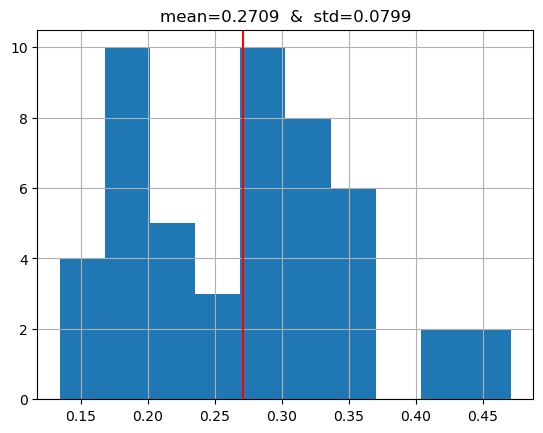

In [7]:
_metrics = metrics[:50]

metric_mean = np.mean(_metrics)
metric_median = np.median(_metrics)
metric_std = np.std(_metrics)

plt.hist(_metrics, bins=10)
plt.axvline(metric_mean, c="r")
plt.title(f"mean={metric_mean:0.4f}  &  std={metric_std:0.4f}")
plt.grid()
plt.show()

***
# inference

In [8]:
predicted_probs = [model.predict(test[input_cols]) for model in models]
predicted_probs = np.mean(predicted_probs, axis=0)
predicted_probs

array([0.10959411, 0.10959411, 0.10959411, 0.10959411, 0.10959411])

In [9]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs
sub["class_1"] = predicted_probs
sub.describe()

,class_0,class_1
count,5.000000e+00,5.000000
mean,8.904059e-01,0.109594
std,1.241267e-16,0.000000
min,8.904059e-01,0.109594
25%,8.904059e-01,0.109594
50%,8.904059e-01,0.109594
75%,8.904059e-01,0.109594
max,8.904059e-01,0.109594


In [10]:
sub.to_csv("submission.csv", index=False)

***